In [1]:
# import matplotlib
# matplotlib.use('Agg')

from matplotlib.pyplot import *
import matplotlib.pyplot as plt

import numpy as np
import os, glob
import datetime
from netCDF4 import Dataset
from collections import namedtuple
from data import anomaly,global_average
from scipy import stats

In [2]:
modelRun = namedtuple('modelRun', ('t', 'ts','t_trop','ts_trop','flux'))
modelType = namedtuple('modelType', ('piControl','abrupt4xCO2'))

def readFile(modx,runx):
	"""read global and tropical avg. nc file"""
	fni=Dataset('cmip5/{0}.{1}.nc'.format(mn,runx))
	ovar=[]
	for ii in ['flux','ta','tas','t_trop','tas_trop']:
		ovar.append(anomaly(fni[ii][:].squeeze()))
	modout=modelRun(flux=ovar[0],t=ovar[1],ts=ovar[2],t_trop=ovar[3],ts_trop=ovar[4])
	return modout

In [3]:
skip=16*12;length=16

# get names of models
fn=glob.glob('cmip5/*.{}.nc'.format('piControl'))
models=[ii.split('/')[1] for ii in fn]
models=[ii.split('.')[0] for ii in models]
models.sort()
models.remove('CSIRO-Mk3-6-0')

feedbacks={}
for mn in models:
	piC=readFile(mn,'piControl')	
	abrupt=readFile(mn,'abrupt4xCO2')
	feedbacks[mn]=modelType(piControl=piC,abrupt4xCO2=abrupt)
	print('{} '.format(mn),end="")
	sys.stdout.flush()
print()

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R HadGEM2-ES INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC-ESM MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 


In [4]:
modelOutput={}
for mn in models:
	print('{} '.format(mn),end="")
	sys.stdout.flush()

	## analyze the run
	m1all=[];abrupt=[]
	for tvar in 'ts,t_trop,t'.split(','):
		
		mod1=feedbacks[mn].piControl # control run
		s=len(mod1.t)

		commandStr='tg=mod1.{}'.format(tvar)
		exec(commandStr)

		# flux is the same for all calcs
		flux=mod1.flux
		
		m1=[]
		for ii in range(0,s-length*12,skip):
			indx=range(ii,ii+length*12)
			fitx=stats.linregress(anomaly(tg[indx]),anomaly(flux[indx]))
			m1.append(fitx[0])

		m1all.append(m1)

		# calculate lambda for abrupt runs
		a1=[]
		mod1=feedbacks[mn].abrupt4xCO2

		flux=mod1.flux # fluxes are the same for all calcs
		exec(commandStr)

		tg=tg[:len(tg)//12*12];tg=tg.reshape(len(tg)//12,12).mean(axis=1)
		flux=flux[:len(flux)//12*12];flux=flux.reshape(len(flux)//12,12).mean(axis=1)

		ts=mod1.ts[:len(mod1.ts)//12*12];ts=ts.reshape(len(ts)//12,12).mean(axis=1)
		tt=mod1.t_trop[:len(mod1.t_trop)//12*12];tt=tt.reshape(len(tt)//12,12).mean(axis=1)
		
		a1.append(stats.linregress(tg,flux).slope)
		a1.append(stats.linregress(tg[20:],flux[20:]).slope)
		a1.append(stats.linregress(tt,ts).slope)
		abrupt.append(a1)

	modelOutput[mn]=modelType(piControl=m1all,abrupt4xCO2=abrupt)

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R HadGEM2-ES INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC-ESM MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 

In [5]:
def colorplot(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

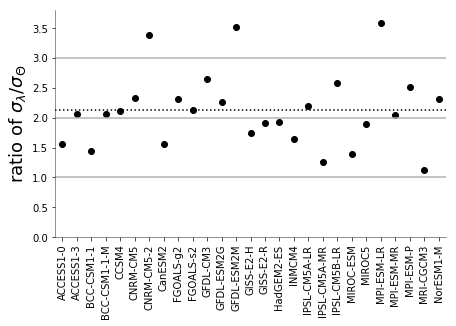

In [7]:
values1=np.array([[np.std(modelOutput[ii].piControl[jj]) for ii in models] for jj in [0,1]])
values2=values1[0,]/values1[1,]

figure(figsize=(7,5))
plt.subplots_adjust(bottom=0.25,hspace=0)

plot(values2,'ko')

xlim(-0.5,len(models)-0.5)
ylabel('ratio of $\sigma_\lambda$/$\sigma_\Theta$',fontsize=18)

gca().set_xticks(range(len(models)))
gca().set_xticklabels(models,rotation='90')

ylim(0,3.8)
axhline(1,color='0.7');axhline(2,color='0.7');axhline(3,color='0.7')
axhline(np.average(values2),color='k',ls='dotted')
colorplot(gca())

savefig('fig9.eps')

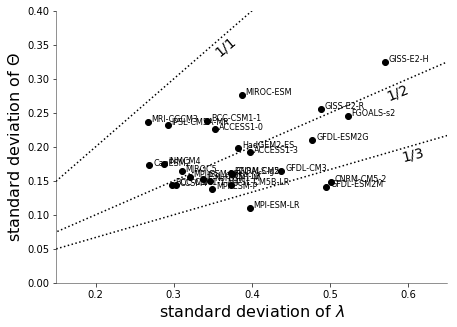

In [13]:
# plot showing that variability in control runs vs. Ts is greater than vs. T500,tropics
figure(figsize=(7,5))
# values1=[[np.percentile(modelOutput[ii].piControl[jj],95)-\
# 	np.percentile(modelOutput[ii].piControl[jj],5) for ii in models] for jj in [0,1]]
values1=[[np.std(modelOutput[ii].piControl[jj]) for ii in models] for jj in [0,1]]
plot(values1[0],values1[1],'ko')
for ii,mn in enumerate(models):
        annotate('{}'.format(mn), (values1[0][ii]+0.005,values1[1][ii]),fontsize=8)
xlim(0.15,0.65);ylim(0,0.4)#;grid()
xlabel('standard deviation of $\lambda$',fontsize=16)
ylabel('standard deviation of $\Theta$',fontsize=16)
plot(np.linspace(0,3),np.linspace(0,3),'k',ls='dotted')
plot(np.linspace(0,3),np.linspace(0,3)/2,'k',ls='dotted')
plot(np.linspace(0,3),np.linspace(0,3)/3,'k',ls='dotted')
annotate('1/1',(0.35,0.35),fontsize=14,rotation=40)
annotate('1/2',(0.57,0.28),fontsize=14,rotation=22)
annotate('1/3',(0.59,0.187),fontsize=14,rotation=14)
# plot([1.158],[0.416],'ro',markersize=10) # values calculated in fig3.py
colorplot(gca())
# savefig('figS4.eps')

estimate uncertainty in $\Theta_{control}$

In [52]:
## estimate standard deviation divided by sqrt(number of samples)
jj=1
values1=[];neff=[]
for ii in models:
    datai=modelOutput[ii].piControl[jj]
    lag1=np.abs(stats.linregress(datai[1:],datai[:-1]).rvalue) # make positive for upper limit
    neff=len(datai)#*(1-lag1)/(1+lag1)
    values1.append(np.std(datai)/np.sqrt(neff))

In [53]:
# print results
np.average(values1),np.max(values1),np.min(values1)

(0.031815415383079637, 0.055053892367657578, 0.014431327940478187)